In [1]:
!git clone https://github.com/sofiyabogakovskaya/HopfieldAM.git

Cloning into 'HopfieldAM'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 496 (delta 67), reused 107 (delta 35), pack-reused 349 (from 1)
Receiving objects: 100% (496/496), 4.20 MiB | 15.26 MiB/s, done.
Resolving deltas: 100% (252/252), done.


---
# Install the requirements

In [2]:
!pip install -r HopfieldAM/requirements.txt
# !pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 13.6 MB/s eta 0:00:00


# Create root

In [3]:
!pip install rootutils

!touch /content/HopfieldAM/.project-root

import os
import rootutils

rootutils.setup_root(os.path.abspath('/content/HopfieldAM'), indicator=".project-root", pythonpath=True, dotenv=True, cwd=True)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil
from argparse import Namespace

import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import jax

import equinox as eqx
import optax
import numpy as np

import tensorflow_datasets as tfds


from models import get_model
from losses import get_batch_loss
from datasets.dataset_loader import get_dataloader
from datasets.get_dimension import get_dimension
from src.train import train
from src.test import test
from utils.visualization import plot_metrics, create_batch_to_compute_energy, plot_energy, plot_energy_dot
from utils.integrate_trajectory import integrate_trajectory, get_energy
from utils.logger import new_run_id, log_experiment, log_summary
from utils.parse_config import parse_config
from utils.config import CONFIG
from utils.activation_map import ACTIVATION_MAP
from utils.for_inference import get_best_checkpoint_path, load_best_model


from tqdm.auto import tqdm
import os
import glob
import re

/content/HopfieldAM/models/Hopfield.py:14: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  g: Callable = eqx.static_field()


# plot energy dot fix

In [53]:
# --- memory-efficient energy derivative (no diag/eye) ---
def energy_derivative(model, x):
    """
    Compute scalar energy derivative E_dot for state x without forming full diag/eye matrices.
    Uses:
      E_dot = (-W @ g + y).T @ D @ (I - y y^T) @ (W @ g)
    where D = diag(y > 0). We implement D @ v as elementwise multiplication.
    """
    # normalize x (watch for zero-norm)
    norm_x = jnp.linalg.norm(x)
    # avoid divide-by-zero (if needed)
    y = jnp.where(norm_x > 0, x / norm_x, x)

    g = model.g(y)         # shape (dim,)
    W = model.W            # shape (dim, dim)
    v = W @ g              # shape (dim,)

    # compute (I - y y^T) @ v = v - y * (y @ v)
    y_dot_v = jnp.vdot(y, v)    # scalar
    M = v - y * y_dot_v         # shape (dim,)

    # D = (y > 0).astype(float), so D @ M = D * M (elementwise)
    D = (y > 0).astype(x.dtype)
    DM = D * M

    left = -v + y               # (-W g + y)
    E_dot = jnp.vdot(left, DM)  # scalar

    return E_dot


In [54]:
# --- memory-efficient get_energy_dot: process samples one-by-one ---
def get_energy_dot(model, X_batch, y_batch, dt, t1, samples):
    # reduced-precision ts
    N_steps = int(t1 / dt)
    ts = jnp.linspace(0.0, t1, N_steps + 1, dtype=jnp.float32)

    X = X_batch[:samples].astype(jnp.float32)
    y = y_batch[:samples]

    # We'll compute per-sample to avoid storing (samples, T, dim) in memory.
    batch_E_dot_list = []
    for i in range(X.shape[0]):
        x0 = X[i]
        traj = integrate_trajectory(model, x0, dt, t1, ts)   # shape (T, dim)
        # For a single trajectory we can vmap energy_derivative over times
        E_dot_traj = jnp.asarray([energy_derivative(model, xi) for xi in traj])
        batch_E_dot_list.append(E_dot_traj)

    # stack into (samples, T)
    batch_E_dot = jnp.stack(batch_E_dot_list, axis=0)

    return X, y, ts, batch_E_dot


In [55]:
def plot_energy_dot(run_id, model, X_batch, y_batch, dt, t1, samples, save_plot=False):
    X, y, ts, batch_E = get_energy_dot(model, X_batch, y_batch, dt, t1, samples)

    output_dir = f"experiments/{run_id}"
    plot_path = os.path.join(output_dir, f"energy_plot_{samples}samples.png")

    # plot, coloring by digit
    plt.figure(figsize=(10, 6))
    colors = plt.get_cmap("tab10")  # 10 distinct colors

    for digit in range(10):
        idx = jnp.where(y == digit)[0]
        for i in idx:
            plt.plot(ts, batch_E[i],
                    color=colors(digit),
                    label=str(digit) if i == idx[0] else None,
                    alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Energy deriviative")
    plt.title(f"{run_id}: Energy derivative for {samples} samples (t ∈ [0,{t1}])")
    plt.legend(title="Digit", ncol=5, fontsize="small")
    plt.grid(alpha=0.4)
    plt.ylim(-50, 100)
    plt.ylim(bottom=min(batch_E.flatten()) * 1.1)  # show negative energies clearly

    if save_plot:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")

    plt.show()
    plt.close("all")

In [5]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-3"

In [68]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,

    activation = "relu",
    dt=0.01,
    t1=5.0,

    N_classes=10,
)

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir)

In [60]:
X, y = create_batch_to_compute_energy(
    numbers=[0, 1, 2],
    each_number_samples=5,
    dataset_name=args.dataset_name,
    split="test"
)
samples = y.shape[0]

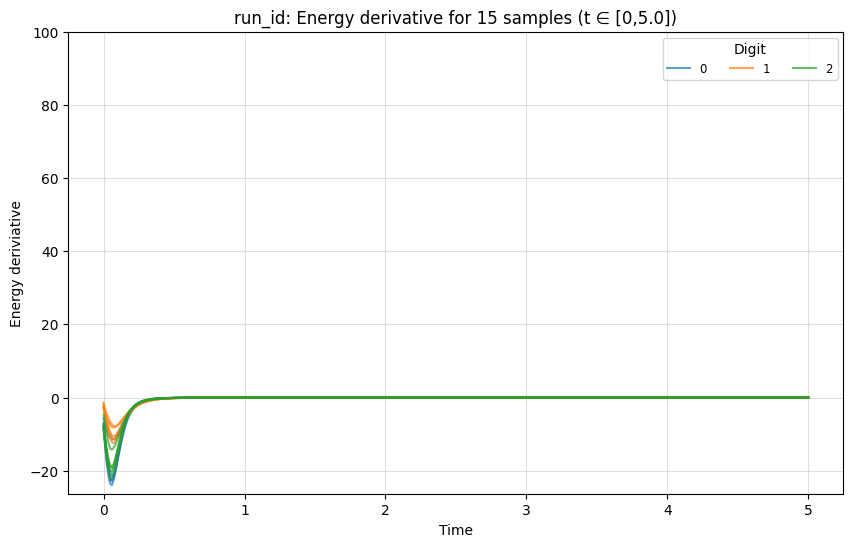

In [61]:
plot_energy_dot("run_id", best_model, X, y, args.dt, args.t1, samples, save_plot=False)

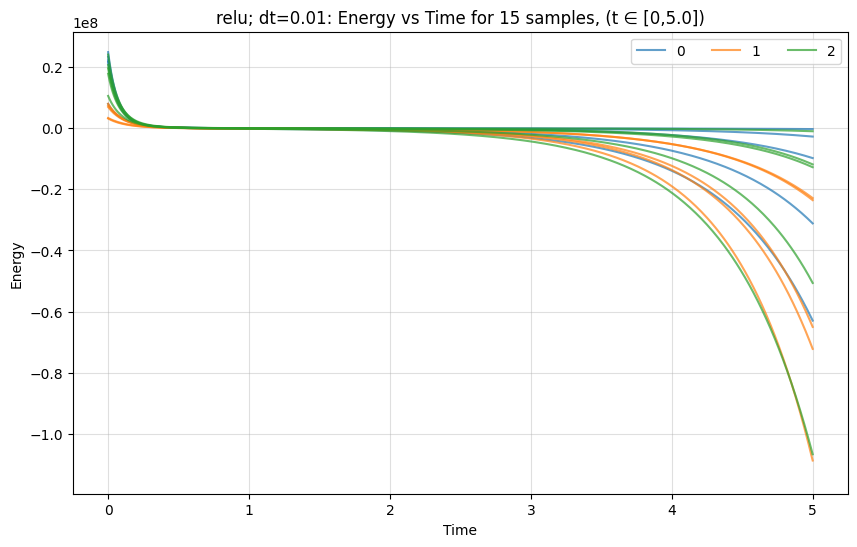

In [62]:
plot_energy(
    f"{args.activation}; dt={args.dt}",
    best_model,
    X,
    y,
    args.dt,
    args.t1,
    samples,
    save_plot=False,
    # ylim=(330, 370),
    # xlim=(10, 15.5),
    plot_only_mean=False
)

# observing trajectories

In [31]:
from utils.trajectory_length import trajectory_direction, trajectory_length

In [32]:
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

In [33]:
x_0 = X[0]

In [34]:
x_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
traj_length = trajectory_length(x_traj)
traj_dir = trajectory_direction(x_traj)

In [35]:
x_vec_lengh_over_t = jnp.linalg.norm(x_traj, axis=-1)

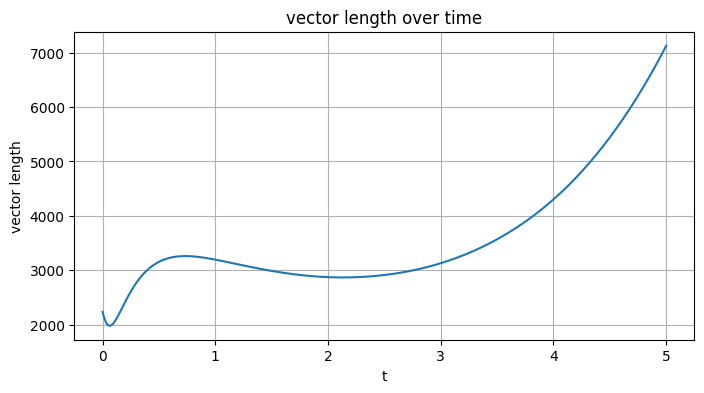

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(ts, x_vec_lengh_over_t)
plt.xlabel("t")
plt.ylabel("vector length")
plt.title("vector length over time")
plt.grid(True)
plt.show()

# let's look at a few samples:

In [77]:
args.t1 = 5.0

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir)

In [78]:
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

In [79]:
digits = [0, 1, 2]
num_samples = 5

samples for 0


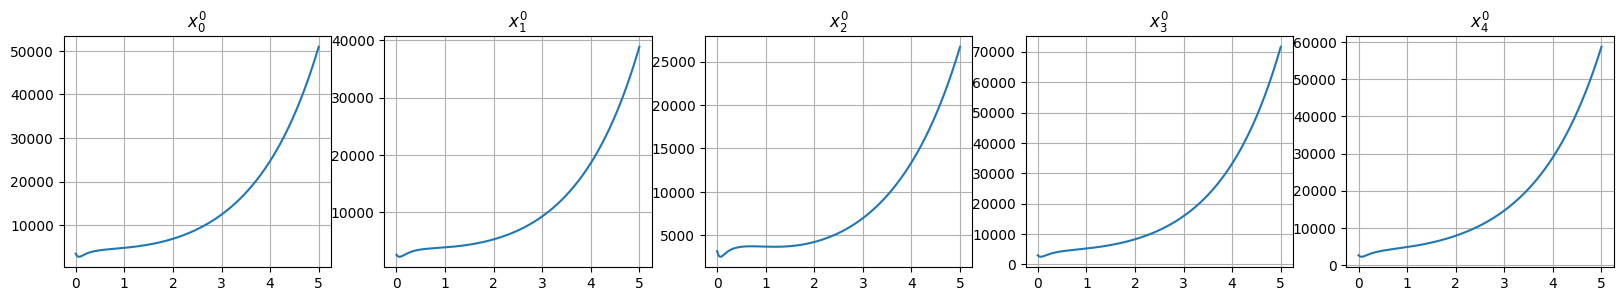

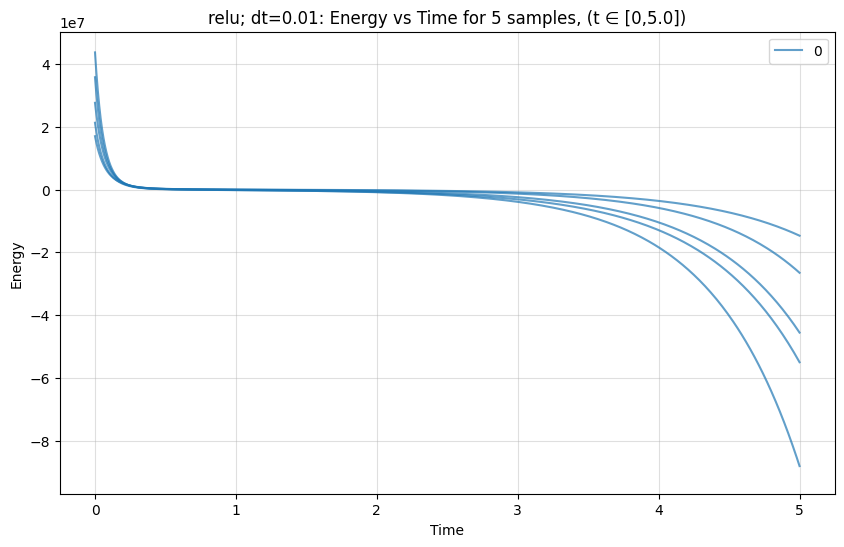

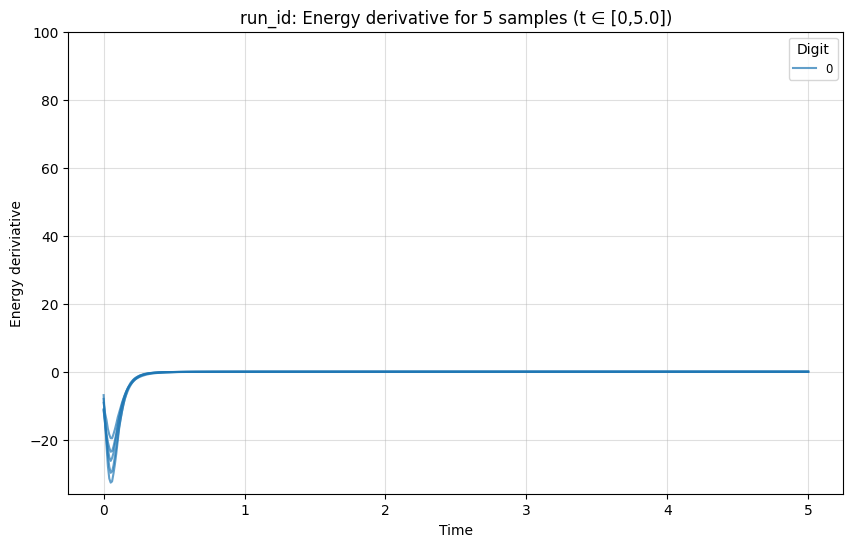

samples for 1


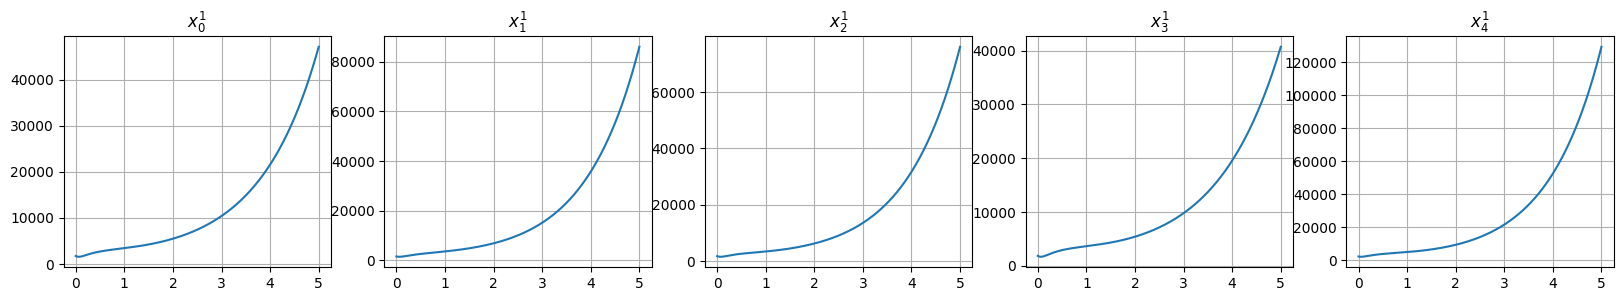

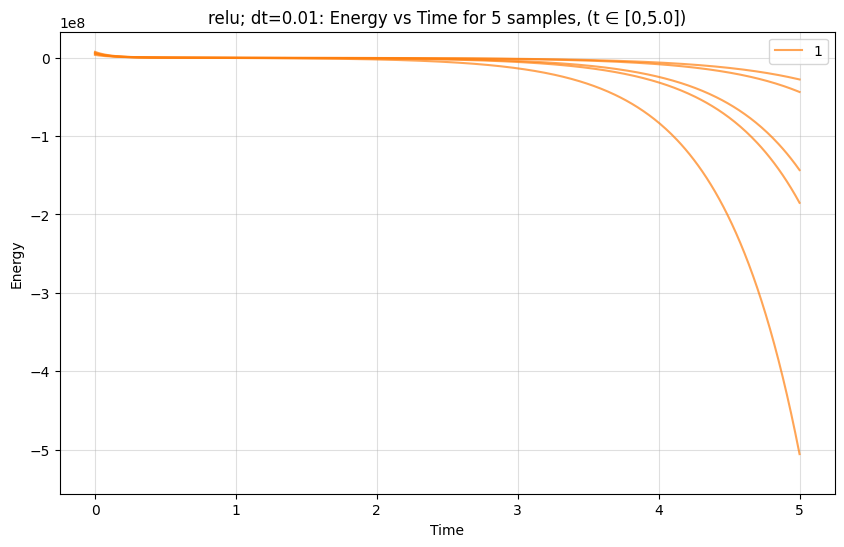

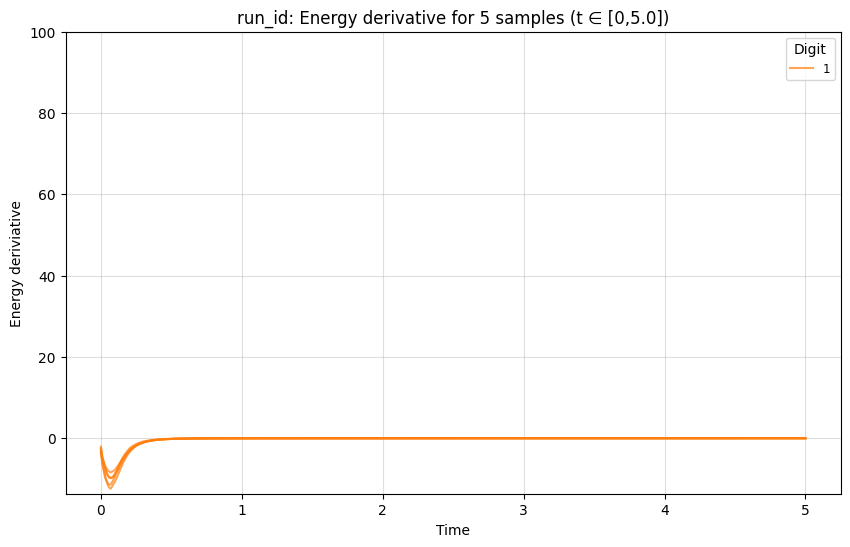

samples for 2


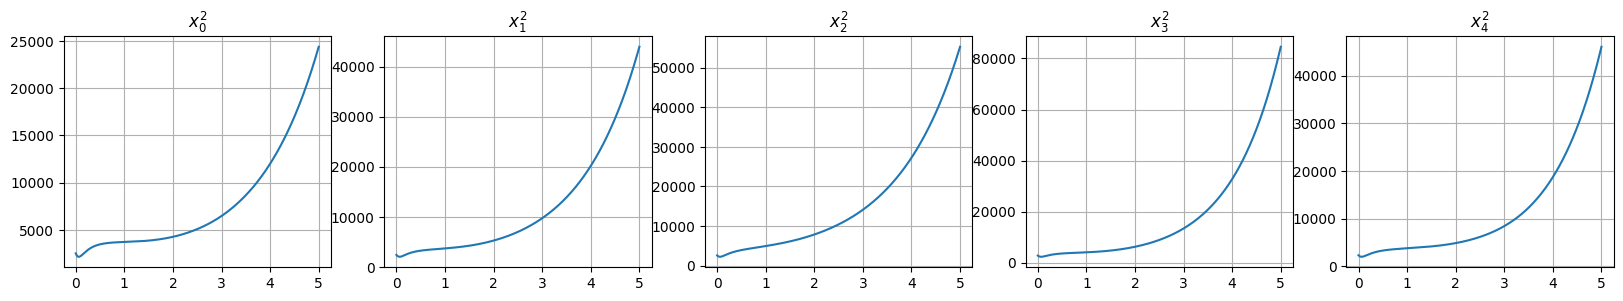

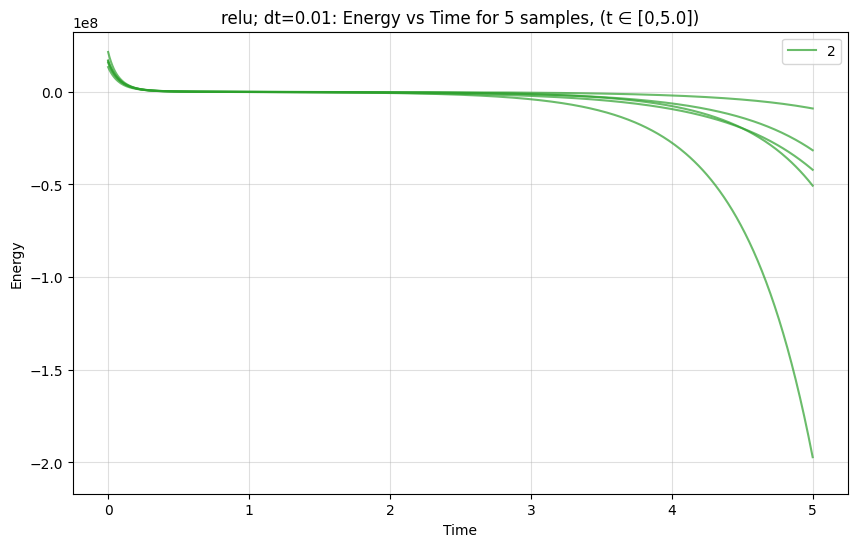

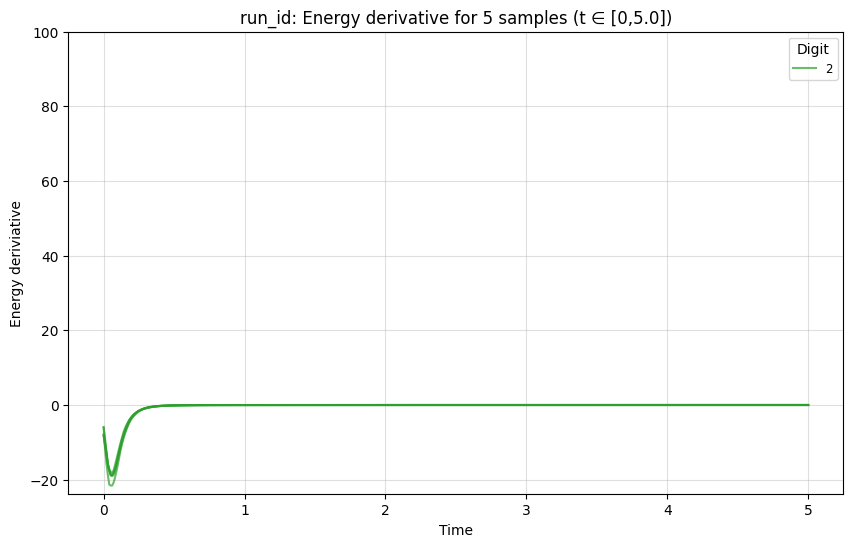

In [80]:
for i in digits:
    fig = plt.figure(figsize=(num_samples*4, 3))
    print(f"samples for {i}")
    X, y = create_batch_to_compute_energy(
    numbers=[i],
    each_number_samples=num_samples,
    dataset_name=args.dataset_name,
    split="test"
    )
    samples = y.shape[0]
    for j in range(num_samples):
        ax = fig.add_subplot(1, num_samples, j+1)
        plt.sca(ax)
        ax.set_title(f"$x_{j}^{i}$")

        x_0 = X[j]
        x_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
        x_vec_lengh_over_t = jnp.linalg.norm(x_traj, axis=-1)

        # plt.figure(figsize=(8, 4))
        plt.plot(ts, x_vec_lengh_over_t)
        # plt.xlabel("t")
        # plt.ylabel("vector length")
        # plt.title(f"vector length over time (sample of {i})")
        plt.grid(True)
    plt.show()
    plot_energy(
        f"{args.activation}; dt={args.dt}",
        best_model,
        X,
        y,
        args.dt,
        args.t1,
        samples,
        save_plot=False,
        # ylim=(330, 370),
        # xlim=(10, 15.5),
        plot_only_mean=False
    )
    plot_energy_dot("run_id", best_model, X, y, args.dt, args.t1, samples, save_plot=False)
